In [7]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pylab as plt
import matplotlib.pyplot as pyplt
from matplotlib import gridspec

import sklearn
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectPercentile, chi2

import cmath
import random

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import svm
import scipy as sp
import scipy.fftpack

import lib
import library

# Генерация данных

In [8]:
dataset = library.creat_dataset()
dataset.head()

[INFO] -- Selected sensor data types: ['attitude', 'userAcceleration']
[INFO] -- Selected activites: ['dws', 'ups', 'wlk', 'jog', 'std', 'sit']
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(1412865, 13)


,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id,weight,height,age,gender,trial
0,1.528132,-0.733896,0.696372,0.294894,-0.184493,0.377542,0.0,0.0,102.0,188.0,46.0,1.0,1.0
1,1.527992,-0.716987,0.677762,0.219405,0.035846,0.114866,0.0,0.0,102.0,188.0,46.0,1.0,1.0
2,1.527765,-0.706999,0.670951,0.010714,0.134701,-0.167808,0.0,0.0,102.0,188.0,46.0,1.0,1.0
3,1.516768,-0.704678,0.675735,-0.008389,0.136788,0.094958,0.0,0.0,102.0,188.0,46.0,1.0,1.0
4,1.493941,-0.703918,0.672994,0.199441,0.353996,-0.044299,0.0,0.0,102.0,188.0,46.0,1.0,1.0


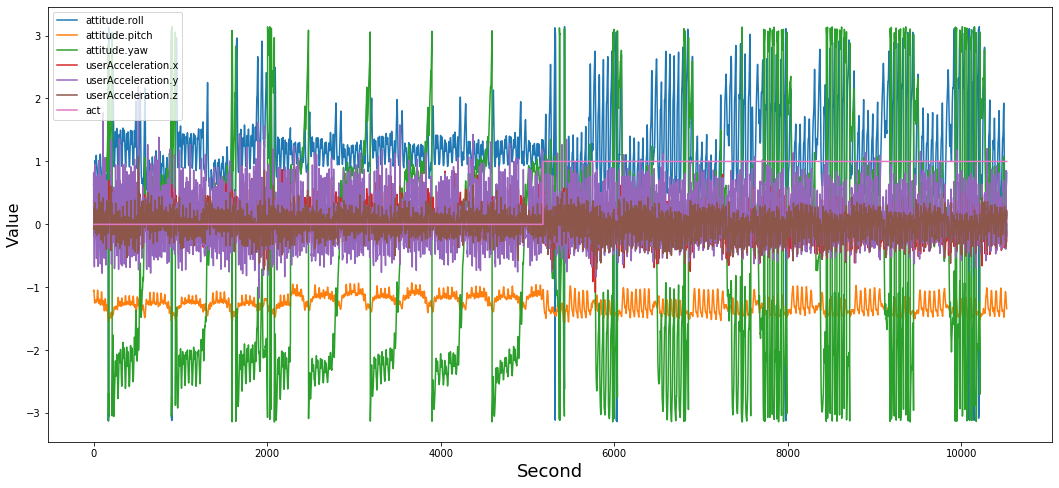

In [9]:
data = dataset.loc[dataset['id'] == 2].loc[(dataset['trial'] > 0)&(dataset['trial'] < 5)]
data = data[['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z','act']]
data.index = np.arange(len(data))

T = 100
K = 2
discrete = T//10
size_data = 10000

X_data = data.values[:size_data, :6]
List_of_x = np.arange(2*T, X_data.shape[0] - T) #ось времени

library.drow_data_multi(data)

# Извлечение признаков

Сингулярные числа (по 2 на ряд) разложения фазовой траектории:

In [11]:
N_comp = 2

def get_spectrum_names(n):
    feature_names = []
    for ax in ['roll', 'pitch', 'yaw', 'x_acc', 'y_acc', 'z_acc']:
        for i in range(n):
            feature_names += [ax + '_' + 'specrum_' + str(i)]
    return feature_names

feature_names = get_spectrum_names(N_comp)

# phase track для каждой точки от T до len(phase_track) - (N, len, T)
phase_track = lib.return_phase_track(X_data, T) 

# basis vector - 2 компоненты сингулярного разложения в точках 2T,2T+discrete.. max-T-discrete - (len, 2*N)
List_of_basis_vector, List_of_basis_vector_s, List_of_basis_vector_c = lib.local_basis_multi(phase_track, T = T, 
                                                                      N_components = N_comp, discrete = discrete)

specrum_feats = pd.DataFrame(List_of_basis_vector_s,columns = feature_names)
specrum_feats.to_csv("../data/features/specrum.csv", index=False)
specrum_feats

,roll_specrum_0,roll_specrum_1,pitch_specrum_0,pitch_specrum_1,yaw_specrum_0,yaw_specrum_1,x_acc_specrum_0,x_acc_specrum_1,y_acc_specrum_0,y_acc_specrum_1,z_acc_specrum_0,z_acc_specrum_1
0,14.836874,14.787485,5.841868,3.545568,20.418731,20.312302,6.937398,6.881794,24.430211,24.282154,4.583129,4.519279
1,29.134286,25.741311,11.253231,7.376066,145.731167,75.788984,8.449453,7.923344,26.865370,26.518440,6.000043,5.831359
2,29.647961,25.782190,10.665265,7.513298,155.281533,80.796500,8.588066,7.859102,26.587422,26.232987,6.030939,5.784481
3,30.763330,25.768567,10.008470,7.652122,164.365728,86.105366,8.609381,7.996404,26.384111,26.141653,6.344943,5.766317
4,31.527295,26.384042,9.331390,7.860969,172.309440,89.911562,8.905632,7.897306,26.115046,25.985899,6.801666,5.774051
...,...,...,...,...,...,...,...,...,...,...,...,...
965,53.749824,48.085340,9.768407,8.781580,64.316289,51.492530,10.039630,9.802534,17.093352,16.716554,11.976297,11.583012
966,53.606199,50.379492,9.245384,8.598202,64.151557,58.513873,9.938119,9.723660,17.237597,16.276469,11.993024,11.769044
967,52.748807,50.597471,8.731247,8.296542,64.566485,59.616817,9.908263,9.636368,17.144528,16.418879,12.236812,11.880911
968,52.340709,50.232373,8.561062,7.631391,67.975461,62.161190,9.949131,9.573736,17.015152,16.847130,12.379184,12.053060


Параметры авторегрессии (по 10 на ряд):




In [12]:
n = 10   # with free coef

def get_autoregressive_names(n):
    feature_names = []
    for ax in ['roll', 'pitch', 'yaw', 'x_acc', 'y_acc', 'z_acc']:
        for i in range(n):
            feature_names += [ax + '_' + 'autoreg_' + str(i)]
    return feature_names

feature_names = get_autoregressive_names(n)

def get_autoreg_feat_segm(ts, n):
    m = ts.shape[1]
    features = []
    for row in ts:
        X = np.zeros([m-n, n])
        Y = np.zeros(m-n)
        for i in range(m-n):
            X[i, :] = row[i:i+n]
            Y[i] = row[i+n]
        lr = LinearRegression()
        lr.fit(X, Y)
        features.append(lr.intercept_)
        features.extend(lr.coef_)  
    return features

def get_autoreg_features(X_data, n, discrete):
    if(n == 0): return np.asarray([])
    size = (X_data.shape[0]-3*T)//discrete
    params_autoreg = [None]*size
    for i in range(size):
        segm = lib.return_h(X_data, 2*T+i*discrete, T)       
        params_autoreg[i] = get_autoreg_feat_segm(segm, n)   #n*N_row features
    return(np.asarray(params_autoreg))
    
params_autoreg = get_autoreg_features(X_data, n-1, discrete)
autoreg_feats = pd.DataFrame(params_autoreg,columns = feature_names)
autoreg_feats.to_csv("../data/features/autoreg_feats.csv", index=False)
autoreg_feats

,roll_autoreg_0,roll_autoreg_1,roll_autoreg_2,roll_autoreg_3,roll_autoreg_4,roll_autoreg_5,roll_autoreg_6,roll_autoreg_7,roll_autoreg_8,roll_autoreg_9,...,z_acc_autoreg_0,z_acc_autoreg_1,z_acc_autoreg_2,z_acc_autoreg_3,z_acc_autoreg_4,z_acc_autoreg_5,z_acc_autoreg_6,z_acc_autoreg_7,z_acc_autoreg_8,z_acc_autoreg_9
0,0.583054,-0.097716,0.016372,0.238078,-0.404402,0.023221,0.461903,-0.747867,-0.024280,0.654515,...,0.029366,-0.022335,-0.094899,-0.077917,0.017202,0.171048,-0.091230,-0.287724,0.157214,0.763735
1,0.509652,-0.084207,0.020585,0.242659,-0.391762,0.028804,0.467382,-0.740550,-0.021280,0.657549,...,0.035587,-0.045559,0.091305,-0.185036,-0.145394,0.216036,0.092387,-0.110472,-0.546815,1.223796
2,0.442416,-0.092501,0.021027,0.266988,-0.394017,0.037442,0.522589,-0.735082,-0.011325,0.728744,...,0.035873,-0.126954,0.231832,-0.290091,-0.040449,0.071551,0.215474,-0.167302,-0.523701,1.213886
3,0.204818,-0.040855,0.042657,0.313897,-0.336901,0.076042,0.604181,-0.695991,0.014976,0.814178,...,0.030852,-0.122115,0.239236,-0.289634,-0.057165,0.094869,0.225599,-0.175939,-0.527718,1.237310
4,0.235698,-0.064600,0.037914,0.312111,-0.356020,0.072136,0.606744,-0.704041,0.015080,0.820449,...,0.037351,-0.135665,0.261033,-0.293583,-0.050038,0.116422,0.186248,-0.168845,-0.496630,1.178553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,0.003925,0.034375,-0.464701,1.221780,-1.227453,0.176845,0.356357,1.124357,-3.218472,2.994052,...,0.001763,-0.011712,-0.044629,0.115507,0.068117,-0.323428,0.197078,-0.221838,-0.127292,1.207802
966,0.004903,0.045503,-0.457172,1.165316,-1.227023,0.271367,0.280298,1.155056,-3.236436,2.999013,...,0.002630,-0.017216,-0.083953,0.141149,0.024605,-0.270816,0.191587,-0.232515,-0.126375,1.182150
967,0.004992,0.060746,-0.497417,1.200166,-1.213889,0.217047,0.315927,1.166839,-3.260875,3.007489,...,0.001788,-0.029797,-0.051925,0.136939,0.004323,-0.246709,0.165922,-0.224944,-0.101257,1.164087
968,0.005992,0.003875,-0.250410,0.730148,-0.654810,-0.221086,0.414050,1.273099,-3.255835,2.957122,...,-0.005454,-0.056651,0.039808,0.125986,0.039988,-0.314199,0.111005,-0.170153,-0.104503,1.259701


Коэффициенты Фурье разложения:

In [13]:
def get_fft_names(n):
    feature_names = []
    for ax in ['roll', 'pitch', 'yaw', 'x_acc', 'y_acc', 'z_acc']:
        for i in range(n):
            feature_names += [ax + '_' + 'fft_' + str(i)]
    return feature_names

feature_names = get_fft_names(T)

def get_fft_features_segm(ts, n):
    m = ts.shape[1]
    features = []
    
    for row in ts:
        h = sp.fftpack.rfft(row, n, axis=-1, overwrite_x=False)
        features.extend(h)
    
    return list(np.array(features)**2)

def get_fft_features(X_data, n, discrete):
    if(n == 0): return np.asarray([])
    size = (X_data.shape[0]-3*T)//discrete
    params_fft = [None]*size
    for i in range(size):
        segm = lib.return_h(X_data, 2*T+i*discrete, T)  
        params_fft[i] = get_fft_features_segm(segm, n)   #n*N_row features
    return(np.asarray(params_fft))
  
params_fft = get_fft_features(X_data, n = T, discrete = discrete)
fft_feats = pd.DataFrame(params_fft,columns = feature_names)
fft_feats.to_csv("../data/features/fft_feats.csv", index=False)
fft_feats

,roll_fft_0,roll_fft_1,roll_fft_2,roll_fft_3,roll_fft_4,roll_fft_5,roll_fft_6,roll_fft_7,roll_fft_8,roll_fft_9,...,z_acc_fft_90,z_acc_fft_91,z_acc_fft_92,z_acc_fft_93,z_acc_fft_94,z_acc_fft_95,z_acc_fft_96,z_acc_fft_97,z_acc_fft_98,z_acc_fft_99
0,4472.564026,27.589922,9.040494,31.829116,156.217279,1.144372,11.894792,0.949990,4.507052,37.435493,...,3.104435e-01,0.009179,0.231486,0.001198,0.507089,0.254591,0.371412,1.141339,0.017643,0.882606
1,4037.908564,30.620292,45.177674,61.785705,129.009267,2.953152,0.260540,3.510376,1.926419,29.683021,...,2.478051e-03,0.305123,0.027681,0.054641,0.139819,0.122019,0.020649,0.069146,0.079291,0.096265
2,4791.740662,24.533620,55.192622,329.249966,40.233799,16.185907,25.224205,5.604929,35.691238,56.163024,...,1.322266e-03,0.337012,0.038910,0.215920,0.011764,0.004692,0.140783,0.112538,0.005611,0.070883
3,6935.356531,455.440369,3.166551,91.066212,781.810064,0.053796,172.456498,16.198783,56.387347,94.778876,...,8.474362e-07,0.064233,0.234201,0.000542,0.176668,0.154227,0.013161,0.116813,0.031801,0.095172
4,7652.232877,401.749918,240.943254,434.096540,417.019676,120.652220,1.080174,1.182647,28.813424,77.341932,...,2.150378e-02,0.000084,0.143860,0.069974,0.002341,0.182701,0.214767,0.004360,0.075637,0.003102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,12741.918782,326.605965,8.284011,112.346022,793.200435,6.944853,165.204387,11.160917,15.005164,0.148805,...,8.785389e-03,0.000092,0.096554,0.000464,0.128751,0.019236,0.054246,0.150079,0.000063,0.078690
966,16956.334789,1038.991985,208.471305,324.754296,91.451291,40.435651,142.900674,2.494376,66.530546,8.384451,...,9.074368e-03,0.005957,0.063576,0.199268,0.010122,0.025582,0.002282,0.176311,0.058744,0.027724
967,18497.680726,515.162379,1105.788984,130.204766,92.609627,74.815329,19.548688,60.387742,0.805364,0.324084,...,2.687777e-03,0.270278,0.010102,0.000003,0.072143,0.017042,0.090540,0.063764,0.128047,0.020050
968,18583.696136,0.718149,1620.140816,36.140894,189.874900,53.478862,45.204048,52.746643,12.719925,0.930047,...,1.812761e-02,0.004847,0.032552,0.041201,0.046279,0.446248,0.013719,0.057636,0.116880,0.004608


# Обучение и оценка точности на спектральных признаках

In [14]:
# features:
#X_feat = np.concatenate((fft_feats, autoreg_feats, specrum_feats), axis = 1)
X_feat = specrum_feats
y = np.asarray([1 if x==1 else 0  for i,x in enumerate(data.values[2*T:size_data-T, 6]) if i % discrete == 0])


# train and test:
#X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.4, random_state=0)
X_train, y_train = X_feat[250:750], y[250:750]
X_test, y_test = np.concatenate((X_feat[:250],X_feat[750:]), axis = 0), np.concatenate((y[:250],y[750:]), axis = 0)

X_train = sklearn.preprocessing.MinMaxScaler().fit_transform(X_train)
X_test = sklearn.preprocessing.MinMaxScaler().fit_transform(X_test)

select_feat = SelectPercentile(chi2)
X_new = select_feat.fit_transform(X_train, y_train)
X_new_check = select_feat.transform(X_test)

In [15]:
clf = svm.SVC(kernel='rbf', C=1)
scores = cross_val_score(clf, X_new, y_train, cv=5)
print("Accuracy cross validation: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

clf = svm.SVC(kernel='rbf',C=1).fit(X_new, y_train)
print('на тестовой выборке: %0.3f' % clf.score(X_new_check, y_test))

Accuracy cross validation: 0.988 (+/- 0.048)
на тестовой выборке: 0.874


# Обучение и оценка точности на признаках авторегрессии

In [16]:
# features:
#X_feat = np.concatenate((fft_feats, autoreg_feats, specrum_feats), axis = 1)
X_feat = autoreg_feats
y = np.asarray([1 if x==1 else 0  for i,x in enumerate(data.values[2*T:size_data-T, 6]) if i % discrete == 0])


# train and test:
#X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.4, random_state=0)
X_train, y_train = X_feat[250:750], y[250:750]
X_test, y_test = np.concatenate((X_feat[:250],X_feat[750:]), axis = 0), np.concatenate((y[:250],y[750:]), axis = 0)

X_train = sklearn.preprocessing.MinMaxScaler().fit_transform(X_train)
X_test = sklearn.preprocessing.MinMaxScaler().fit_transform(X_test)

select_feat = SelectPercentile(chi2)
X_new = select_feat.fit_transform(X_train, y_train)
X_new_check = select_feat.transform(X_test)

In [17]:
clf = svm.SVC(kernel='rbf', C=1)
scores = cross_val_score(clf, X_new, y_train, cv=5)
print("Accuracy cross validation: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

clf = svm.SVC(kernel='rbf',C=1).fit(X_new, y_train)
print('на тестовой выборке: %0.3f' % clf.score(X_new_check, y_test))

Accuracy cross validation: 0.892 (+/- 0.148)
на тестовой выборке: 0.719


# Обучение и оценка точности на коэффициентах Фурье

In [18]:
# features:
#X_feat = np.concatenate((fft_feats, autoreg_feats, specrum_feats), axis = 1)
X_feat = fft_feats
y = np.asarray([1 if x==1 else 0  for i,x in enumerate(data.values[2*T:size_data-T, 6]) if i % discrete == 0])


# train and test:
#X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.4, random_state=0)
X_train, y_train = X_feat[250:750], y[250:750]
X_test, y_test = np.concatenate((X_feat[:250],X_feat[750:]), axis = 0), np.concatenate((y[:250],y[750:]), axis = 0)

X_train = sklearn.preprocessing.MinMaxScaler().fit_transform(X_train)
X_test = sklearn.preprocessing.MinMaxScaler().fit_transform(X_test)

select_feat = SelectPercentile(chi2)
X_new = select_feat.fit_transform(X_train, y_train)
X_new_check = select_feat.transform(X_test)

In [19]:
clf = svm.SVC(kernel='rbf', C=1)
scores = cross_val_score(clf, X_new, y_train, cv=5)
print("Accuracy cross validation: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

clf = svm.SVC(kernel='rbf',C=1).fit(X_new, y_train)
print('на тестовой выборке: %0.3f' % clf.score(X_new_check, y_test))

Accuracy cross validation: 0.982 (+/- 0.048)
на тестовой выборке: 0.851


In [20]:
# features:
X_feat = pd.concat([fft_feats, autoreg_feats, specrum_feats], axis=1)
#X_feat = specrum_feats
y = np.asarray([1 if x==1 else 0  for i,x in enumerate(data.values[2*T:size_data-T, 6]) if i % discrete == 0])


# train and test:
#X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.4, random_state=0)
X_train, y_train = X_feat[250:750], y[250:750]
X_test, y_test = np.concatenate((X_feat[:250],X_feat[750:]), axis = 0), np.concatenate((y[:250],y[750:]), axis = 0)

X_train = sklearn.preprocessing.MinMaxScaler().fit_transform(X_train)
X_test = sklearn.preprocessing.MinMaxScaler().fit_transform(X_test)

select_feat = SelectPercentile(chi2, percentile=2.5)
X_new = select_feat.fit_transform(X_train, y_train)

best_feat = select_feat.get_support()
best = [[x,z] for x,y,z in zip(X_feat.columns, select_feat.get_support(), select_feat.scores_) if y == 1]
best = pd.DataFrame(best) 
print(best)
X_new_check = select_feat.transform(X_test)

                  0           1
0        roll_fft_3   39.071247
1        roll_fft_4   38.475198
2       roll_fft_60   18.505226
3       pitch_fft_0   50.558692
4       pitch_fft_3   31.330616
5       pitch_fft_4   25.436953
6      x_acc_fft_15   17.933941
7      x_acc_fft_16   19.319260
8      y_acc_fft_15   18.771405
9      y_acc_fft_16   20.778096
10      z_acc_fft_7   34.904288
11      z_acc_fft_8   35.987728
12   roll_specrum_0  101.492600
13   roll_specrum_1   96.109849
14  pitch_specrum_1   48.634615
15  z_acc_specrum_0  106.993154
16  z_acc_specrum_1  107.160664


Значимость лучших признаков


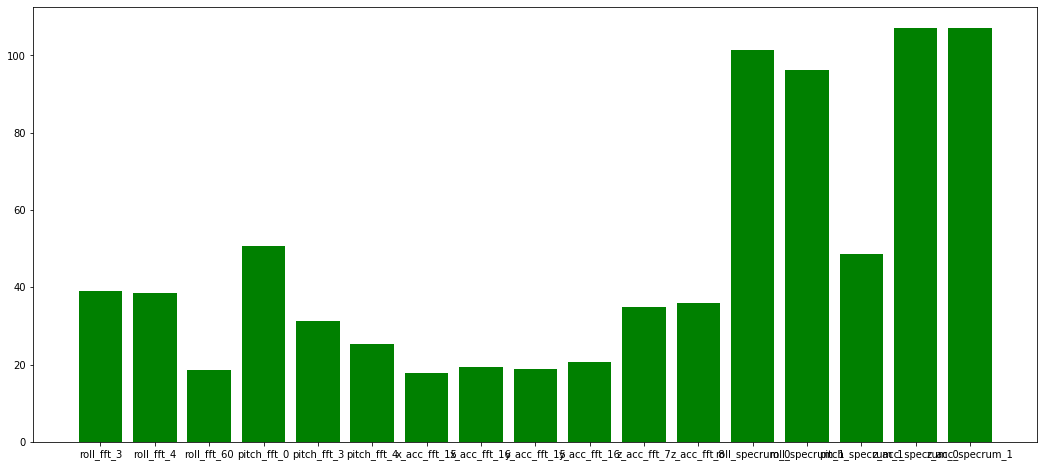

In [25]:
plt.rcParams['figure.figsize'] = (18.0, 8.0)
plt.bar([ str(i) for i in best[0]], best[1], color='g')
print("Значимость лучших признаков")

In [22]:
clf = svm.SVC(kernel='rbf', C=1)
scores = cross_val_score(clf, X_new, y_train, cv=5)
print("Accuracy cross validation: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

clf = svm.SVC(kernel='rbf',C=1).fit(X_new, y_train)
print('на тестовой выборке: %0.3f' % clf.score(X_new_check, y_test))

Accuracy cross validation: 0.986 (+/- 0.056)
на тестовой выборке: 0.851
